In [2]:
## The following packages were recommended based on the article found at https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec
## for data
import numpy as np
import pandas as pd
from collections import Counter


## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for geospatial
import folium
from folium.plugins import MarkerCluster
import geopy

## for machine learning
from sklearn import preprocessing, cluster
import sklearn.neighbors as neighbors
from sklearn.cluster import KMeans
import scipy
from scipy import spatial
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth


## for deep learning
import minisom

## for binary and os operations
import glob
import os
import re

## Import datasets and complete pre-processing

In [3]:
all_csvs = glob.glob(os.path.join('.', '*_us.csv'))
epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)

/var/folders/03/2gj3ww254djf0rl6gy_xrwxh0000gn/T/ipykernel_87731/2000873867.py:2: DtypeWarning: Columns (8,10,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
/var/folders/03/2gj3ww254djf0rl6gy_xrwxh0000gn/T/ipykernel_87731/2000873867.py:2: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
/var/folders/03/2gj3ww254djf0rl6gy_xrwxh0000gn/T/ipykernel_87731/2000873867.py:2: DtypeWarning: Columns (15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri = pd.concat((pd.read_csv(f) for f in all_csvs), ignore_index=True)
/var/folders/03/2gj3ww254djf0rl6gy_xrwxh0000gn/T/ipykernel_87731/2000873867.py:2: DtypeWarning: Columns (8,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  epa_tri

In [4]:
epa_tri.head()

,1. YEAR,2. TRIFD,3. FRS ID,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,8. ST,9. ZIP,10. BIA,...,110. 8.2 - ENERGY RECOVER ON,111. 8.3 - ENERGY RECOVER OF,112. 8.4 - RECYCLING ON SITE,113. 8.5 - RECYCLING OFF SIT,114. 8.6 - TREATMENT ON SITE,115. 8.7 - TREATMENT OFF SITE,116. PRODUCTION WSTE (8.1-8.7),117. 8.8 - ONE-TIME RELEASE,118. PROD_RATIO_OR_ ACTIVITY,119. 8.9 - PRODUCTION RATIO
0,1997,01364RDNYH46MIL,110000308630,VAG USA LLC (FORMERLY RODNEY HUNT),46 MILL ST,ORANGE,FRANKLIN,MA,1364,NaN,...,0.0,0.0,18614.0,6131.0,0.0,0.0,24745.0,0.0,NaN,1.59
1,1997,46550VTCNC900EW,110000399444,VITCO INDUSTRIES INC.,900 E WABASH AVE,NAPPANEE,ELKHART,IN,46550,NaN,...,0.0,0.0,272.0,0.0,335.0,0.0,607.0,0.0,NaN,1.05
2,1997,55387PRTCH902SO,110000425264,PRO-TECH INC,902 S PINE ST,WACONIA,CARVER,MN,55387,NaN,...,0.0,0.0,0.0,20060.0,0.0,0.0,20060.0,0.0,NaN,0.86
3,1997,40216DPNTL4200C,110000378494,CHEMOURS LOUISVILLE PLANT,4200 CAMP GROUND RD,LOUISVILLE,JEFFERSON,KY,40216,NaN,...,0.0,0.0,0.0,0.0,0.0,1915.0,1915.0,0.0,NaN,NaN
4,1997,29348MSCTH800BL,110000353144,MASCOT HOMES INC.,800 BLUE RIDGE ST,INMAN,SPARTANBURG,SC,29349,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [5]:
fda_cdi = pd.read_csv('CDI_with_pop_centers.csv')
fda_cdi.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Population,Latitude,Longitude,Centroid
0,2015,2015,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,NaN,Number,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
1,2014,2014,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,"cases per 100,000",Age-adjusted Rate,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
2,2016,2016,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,"cases per 100,000",Crude Rate,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
3,2014,2014,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,"cases per 100,000",Crude Rate,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."
4,2017,2017,MS,Mississippi,NVSS,Alcohol,Chronic liver disease mortality,NaN,NaN,Number,...,OVERALL,OVR,NaN,NaN,NaN,NaN,2844658,32.56642,-89.593164,"{""type"":""Point"", ""coordinates"":[-89.593164,32...."


In [6]:
plant_locations = epa_tri[['1. YEAR', '2. TRIFD', '4. FACILITY NAME', '8. ST', '12. LATITUDE', '13. LONGITUDE']]
plant_locations.head()

,1. YEAR,2. TRIFD,4. FACILITY NAME,8. ST,12. LATITUDE,13. LONGITUDE
0,1997,01364RDNYH46MIL,VAG USA LLC (FORMERLY RODNEY HUNT),MA,42.589200,-72.304300
1,1997,46550VTCNC900EW,VITCO INDUSTRIES INC.,IN,41.438843,-85.992623
2,1997,55387PRTCH902SO,PRO-TECH INC,MN,44.841410,-93.784750
3,1997,40216DPNTL4200C,CHEMOURS LOUISVILLE PLANT,KY,38.217166,-85.841979
4,1997,29348MSCTH800BL,MASCOT HOMES INC.,SC,35.067242,-82.126491


In [64]:
#plant_locations.shape

In [7]:
# Drop the duplicate rows
plant_locations_unique = plant_locations.drop_duplicates()
#plant_locations_unique.shape

## Create clusters on U.S. map using folium

In [8]:
# Create map centered on geographic center of the United States
us_map = folium.Map(location=[34, -95], zoom_start=4)

In [9]:
marker_cluster = MarkerCluster().add_to(us_map)
for lat, lon in zip(plant_locations_unique['12. LATITUDE'], plant_locations_unique['13. LONGITUDE']):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

In [11]:
#us_map

## Create plant location clusters using k-means

In [12]:
k = 25
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = plant_locations_unique[['12. LATITUDE','13. LONGITUDE']]
plant_locations_unique_X = X.copy()
plant_locations_unique_X["cluster"] = model.fit_predict(X)

# Find the real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     plant_locations_unique_X.drop("cluster", axis=1).values)
plant_locations_unique_X["centroids"] = 0
for i in closest:
    plant_locations_unique_X["centroids"].iloc[i] = 1

# Add the cluster info to the plant_locations_unique dataset
plant_locations_unique[["cluster","centroids"]] = plant_locations_unique_X[["cluster","centroids"]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/03/2gj3ww254djf0rl6gy_xrwxh0000gn/T/ipykernel_87731/398060902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plant_locations_unique_X["centroids"].iloc[i] = 1
/var/folders/03/2gj3ww254djf0rl6gy_xrwxh0000gn/T/ipykernel_87731/398060902.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

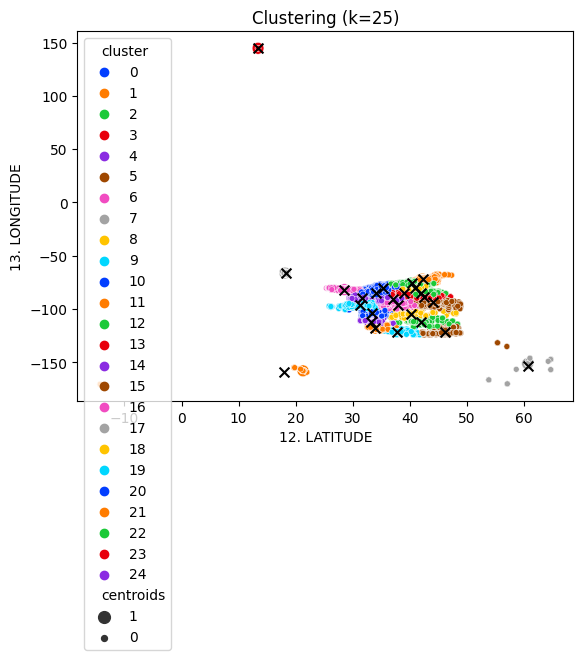

In [13]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x = '12. LATITUDE', 
                y = '13. LONGITUDE', 
                data = plant_locations_unique, 
                palette = sns.color_palette("bright",k),
                hue = 'cluster', 
                size = "centroids", 
                size_order = [1,0],
                legend = "brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s = 50, c = 'black', marker="x")

## Import all categorized CDI Data

In [14]:
cdi_datasets = pd.read_pickle('processed_data/cdi_datasets.pkl')
cdi_datasets = cdi_datasets.reset_index()
cdi_datasets

,Year,LocationAbbr,Centroid,Topic
0,2013,AK,"{""type"":""Point"", ""coordinates"":[-148.716968,61...","[Alcohol, Cancer, Cardiovascular Disease]"
1,2013,AL,"{""type"":""Point"", ""coordinates"":[-86.766233,33....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
2,2013,AR,"{""type"":""Point"", ""coordinates"":[-92.576816,35....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
3,2013,AZ,"{""type"":""Point"", ""coordinates"":[-111.828711,33...","[Alcohol, Cancer, Cardiovascular Disease, Chro..."
4,2013,CA,"{""type"":""Point"", ""coordinates"":[-119.355165,35...","[Alcohol, Cancer, Cardiovascular Disease, Diab..."
...,...,...,...,...
250,2017,VT,"{""type"":""Point"", ""coordinates"":[-72.814309,44....","[Alcohol, Asthma]"
251,2017,WA,"{""type"":""Point"", ""coordinates"":[-121.624501,47...","[Alcohol, Arthritis, Asthma, Chronic Kidney Di..."
252,2017,WI,"{""type"":""Point"", ""coordinates"":[-89.001006,43....","[Alcohol, Asthma]"
253,2017,WV,"{""type"":""Point"", ""coordinates"":[-80.820221,38....","[Alcohol, Arthritis, Asthma, Cardiovascular Di..."


## Use K-Nearest Neighbors to assign each state population center with a cluster

In [20]:
centers = []
for row in model.cluster_centers_:
    centers.append([row[0], row[1]])
tree = spatial.KDTree(centers)

In [19]:
coord_string = r'{"type":"Point", "coordinates":\[(-?\d+\.\d+),(-?\d+\.\d+)\]}'
p = re.compile(coord_string)
mo = p.search('{"type":"Point", "coordinates":[-148.716968,61.288254]}')

In [22]:
cdi_datasets

,Year,LocationAbbr,Centroid,Topic
0,2013,AK,"{""type"":""Point"", ""coordinates"":[-148.716968,61...","[Alcohol, Cancer, Cardiovascular Disease]"
1,2013,AL,"{""type"":""Point"", ""coordinates"":[-86.766233,33....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
2,2013,AR,"{""type"":""Point"", ""coordinates"":[-92.576816,35....","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
3,2013,AZ,"{""type"":""Point"", ""coordinates"":[-111.828711,33...","[Alcohol, Cancer, Cardiovascular Disease, Chro..."
4,2013,CA,"{""type"":""Point"", ""coordinates"":[-119.355165,35...","[Alcohol, Cancer, Cardiovascular Disease, Diab..."
...,...,...,...,...
250,2017,VT,"{""type"":""Point"", ""coordinates"":[-72.814309,44....","[Alcohol, Asthma]"
251,2017,WA,"{""type"":""Point"", ""coordinates"":[-121.624501,47...","[Alcohol, Arthritis, Asthma, Chronic Kidney Di..."
252,2017,WI,"{""type"":""Point"", ""coordinates"":[-89.001006,43....","[Alcohol, Asthma]"
253,2017,WV,"{""type"":""Point"", ""coordinates"":[-80.820221,38....","[Alcohol, Arthritis, Asthma, Cardiovascular Di..."


In [23]:
coord = []
for values in cdi_datasets['Centroid']:
    mo = p.search(values)
    coord.append([float(mo[2]), float(mo[1])])
cdi_datasets['Centroid'] = coord
cdi_datasets

,Year,LocationAbbr,Centroid,Topic
0,2013,AK,"[61.288254, -148.716968]","[Alcohol, Cancer, Cardiovascular Disease]"
1,2013,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
2,2013,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Cardiovascular Di..."
3,2013,AZ,"[33.373506, -111.828711]","[Alcohol, Cancer, Cardiovascular Disease, Chro..."
4,2013,CA,"[35.458606, -119.355165]","[Alcohol, Cancer, Cardiovascular Disease, Diab..."
...,...,...,...,...
250,2017,VT,"[44.081127, -72.814309]","[Alcohol, Asthma]"
251,2017,WA,"[47.341728, -121.624501]","[Alcohol, Arthritis, Asthma, Chronic Kidney Di..."
252,2017,WI,"[43.728544, -89.001006]","[Alcohol, Asthma]"
253,2017,WV,"[38.767195, -80.820221]","[Alcohol, Arthritis, Asthma, Cardiovascular Di..."


In [24]:
nearest_centroid = []
for values in cdi_datasets['Centroid']:
    dd, ii = tree.query(values, k=1)
    nearest_centroid.append(ii)
cdi_datasets['Cluster'] = nearest_centroid

### Once each state's population center has been assigned a cluster from the plants, we join each plant with the table to create associations

In [25]:
epa_tri = epa_tri.reset_index()
tri_chemicals = epa_tri[[
    '2. TRIFD',
    '34. CHEMICAL'
]]
tri_chemicals = tri_chemicals.merge(plant_locations_unique, on='2. TRIFD')
tri_chemicals

,2. TRIFD,34. CHEMICAL,1. YEAR,4. FACILITY NAME,8. ST,12. LATITUDE,13. LONGITUDE,cluster,centroids
0,01364RDNYH46MIL,Nickel,1997,VAG USA LLC (FORMERLY RODNEY HUNT),MA,42.589200,-72.304300,21,0
1,01364RDNYH46MIL,Nickel,1995,VAG USA LLC (FORMERLY RODNEY HUNT),MA,42.589200,-72.304300,21,0
2,01364RDNYH46MIL,Nickel,1993,VAG USA LLC (FORMERLY RODNEY HUNT),MA,42.589200,-72.304300,21,0
3,01364RDNYH46MIL,Nickel,1996,VAG USA LLC (FORMERLY RODNEY HUNT),MA,42.589200,-72.304300,21,0
4,01364RDNYH46MIL,Nickel,1994,VAG USA LLC (FORMERLY RODNEY HUNT),MA,42.589200,-72.304300,21,0
...,...,...,...,...,...,...,...,...,...
1824642,99704SRFRC200AS,"Sulfuric acid (acid aerosols including mists, ...",1994,US DOD USAF CLEAR AFS,AK,64.291900,-149.161800,17,0
1824643,15501GLMRMDRUMA,Xylene (mixed isomers),1994,GILMOUR MFG CO,PA,39.995434,-79.046720,8,0
1824644,13365BRRWSRIVER,"Sulfuric acid (acid aerosols including mists, ...",1994,BURROWS PAPER CORPORATION PULP DIV,NY,43.032270,-74.872070,2,0
1824645,96020SDFRSHWY36,Ammonia,1994,US FOREST SERVICE CHESTER AIRTANKER BASE,CA,40.286435,-121.238819,19,0


## Produce list of all chemicals produced in each cluster

In [26]:
tri_chemicals = tri_chemicals.groupby(by='cluster')['34. CHEMICAL'].apply(list).reset_index()
tri_chemicals

,cluster,34. CHEMICAL
0,0,"[Methanol, Methanol, Methanol, Methanol, Metha..."
1,1,"[Toluene, Toluene, Toluene, Toluene, 1,1,1-Tri..."
2,2,"[Chloromethane, Chloromethane, Chloromethane, ..."
3,3,"[Ethylbenzene, Ethylbenzene, Toluene, Toluene,..."
4,4,"[Trichloroethylene, Trichloroethylene, Trichlo..."
5,5,"[Phosphoric acid, Phosphoric acid, Phosphoric ..."
6,6,"[Hydrogen fluoride, Hydrogen fluoride, Hydroge..."
7,7,"[Carbonyl sulfide, Carbonyl sulfide, Carbonyl ..."
8,8,"[Nitric acid, Nitric acid, Nitric acid, Nitric..."
9,9,"[Ethylene oxide, Ethylene oxide, Ethylene oxid..."


In [27]:
freq = []
for l in tri_chemicals['34. CHEMICAL']:
    c = Counter(l)
    top_10 = [x[0] for x in c.most_common(20)]
    freq.append(top_10)
tri_chemicals['34. CHEMICAL'] = freq

In [28]:
cdi_datasets

,Year,LocationAbbr,Centroid,Topic,Cluster
0,2013,AK,"[61.288254, -148.716968]","[Alcohol, Cancer, Cardiovascular Disease]",17
1,2013,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0
2,2013,AR,"[35.080251, -92.576816]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",14
3,2013,AZ,"[33.373506, -111.828711]","[Alcohol, Cancer, Cardiovascular Disease, Chro...",24
4,2013,CA,"[35.458606, -119.355165]","[Alcohol, Cancer, Cardiovascular Disease, Diab...",1
...,...,...,...,...,...
250,2017,VT,"[44.081127, -72.814309]","[Alcohol, Asthma]",21
251,2017,WA,"[47.341728, -121.624501]","[Alcohol, Arthritis, Asthma, Chronic Kidney Di...",5
252,2017,WI,"[43.728544, -89.001006]","[Alcohol, Asthma]",3
253,2017,WV,"[38.767195, -80.820221]","[Alcohol, Arthritis, Asthma, Cardiovascular Di...",8


In [29]:
tri_chemicals = tri_chemicals.merge(cdi_datasets, left_on='cluster', right_on='Cluster')

In [30]:
tri_chemicals['Pattern'] = tri_chemicals['34. CHEMICAL'] + tri_chemicals['Topic']
tri_chemicals

,cluster,34. CHEMICAL,Year,LocationAbbr,Centroid,Topic,Cluster,Pattern
0,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
1,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,GA,"[33.332208, -83.868887]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
2,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,TN,"[35.795862, -86.397772]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
3,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Chronic Kidney Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
4,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,GA,"[33.332208, -83.868887]","[Alcohol, Arthritis, Cancer, Chronic Kidney Di...",0,"[Xylene (mixed isomers), Toluene, Zinc compoun..."
...,...,...,...,...,...,...,...,...
250,24,"[Sulfuric acid (acid aerosols including mists,...",2013,AZ,"[33.373506, -111.828711]","[Alcohol, Cancer, Cardiovascular Disease, Chro...",24,"[Sulfuric acid (acid aerosols including mists,..."
251,24,"[Sulfuric acid (acid aerosols including mists,...",2014,AZ,"[33.373506, -111.828711]","[Alcohol, Arthritis, Asthma, Cancer, Chronic K...",24,"[Sulfuric acid (acid aerosols including mists,..."
252,24,"[Sulfuric acid (acid aerosols including mists,...",2015,AZ,"[33.373506, -111.828711]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",24,"[Sulfuric acid (acid aerosols including mists,..."
253,24,"[Sulfuric acid (acid aerosols including mists,...",2016,AZ,"[33.373506, -111.828711]","[Alcohol, Arthritis, Chronic Kidney Disease, C...",24,"[Sulfuric acid (acid aerosols including mists,..."


In [31]:
tri_chemicals['Pattern'] = tri_chemicals['Pattern'].apply(lambda x: list(set(x)))
tri_chemicals

,cluster,34. CHEMICAL,Year,LocationAbbr,Centroid,Topic,Cluster,Pattern
0,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,[Chromium compounds (except for chromite ore m...
1,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,GA,"[33.332208, -83.868887]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,[Chromium compounds (except for chromite ore m...
2,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2013,TN,"[35.795862, -86.397772]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",0,[Chromium compounds (except for chromite ore m...
3,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,AL,"[33.001471, -86.766233]","[Alcohol, Arthritis, Cancer, Chronic Kidney Di...",0,[Chromium compounds (except for chromite ore m...
4,0,"[Xylene (mixed isomers), Toluene, Zinc compoun...",2014,GA,"[33.332208, -83.868887]","[Alcohol, Arthritis, Cancer, Chronic Kidney Di...",0,[Chromium compounds (except for chromite ore m...
...,...,...,...,...,...,...,...,...
250,24,"[Sulfuric acid (acid aerosols including mists,...",2013,AZ,"[33.373506, -111.828711]","[Alcohol, Cancer, Cardiovascular Disease, Chro...",24,[Chromium compounds (except for chromite ore m...
251,24,"[Sulfuric acid (acid aerosols including mists,...",2014,AZ,"[33.373506, -111.828711]","[Alcohol, Arthritis, Asthma, Cancer, Chronic K...",24,[Chromium compounds (except for chromite ore m...
252,24,"[Sulfuric acid (acid aerosols including mists,...",2015,AZ,"[33.373506, -111.828711]","[Alcohol, Arthritis, Cancer, Cardiovascular Di...",24,[Chromium compounds (except for chromite ore m...
253,24,"[Sulfuric acid (acid aerosols including mists,...",2016,AZ,"[33.373506, -111.828711]","[Alcohol, Arthritis, Chronic Kidney Disease, C...",24,[Chromium compounds (except for chromite ore m...


In [32]:
tri_chemicals = tri_chemicals.groupby('cluster')['Pattern'].sum()
tri_chemicals.apply(lambda x: list(set(x)))
tri_chemicals

cluster
0     [Chromium compounds (except for chromite ore m...
1     [Chromium compounds (except for chromite ore m...
2     [Chromium compounds (except for chromite ore m...
3     [Chromium compounds (except for chromite ore m...
4     [Chromium compounds (except for chromite ore m...
5     [Chromium compounds (except for chromite ore m...
6     [Chromium compounds (except for chromite ore m...
8     [Chromium compounds (except for chromite ore m...
9     [Chromium compounds (except for chromite ore m...
10    [Chromium compounds (except for chromite ore m...
11    [Chromium compounds (except for chromite ore m...
12    [Cardiovascular Disease, Phosphoric acid, Nitr...
14    [Chromium compounds (except for chromite ore m...
15    [Cardiovascular Disease, Styrene, Phosphoric a...
16    [Chromium compounds (except for chromite ore m...
17    [Chromium compounds (except for chromite ore m...
18    [Chromium compounds (except for chromite ore m...
20    [Cardiovascular Disease, Styrene, 

## Mine the patterns

In [33]:
data = tri_chemicals.to_list()

In [34]:
te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
df = pd.DataFrame(te_ary, columns=te.columns_)
df.to_csv('processed_data/fpgrowth.csv', index=False)

In [35]:
patterns = fpgrowth(df, min_support=0.6, use_colnames=True)

In [36]:
patterns[patterns['itemsets'].map(len) > 1]

,support,itemsets
27,1.000000,"(Alcohol, Cardiovascular Disease)"
28,1.000000,"(Toluene, Cardiovascular Disease)"
29,1.000000,"(Alcohol, Toluene)"
30,1.000000,"(Alcohol, Toluene, Cardiovascular Disease)"
31,1.000000,"(Toluene, Sulfuric acid (acid aerosols includi..."
...,...,...
907514,0.636364,"(Copper, Cardiovascular Disease, Nitric acid, ..."
907515,0.636364,"(Copper, Nitric acid, Xylene (mixed isomers), ..."
907516,0.636364,"(Copper, Cardiovascular Disease, Nitric acid, ..."
907517,0.636364,"(Copper, Cardiovascular Disease, Nitric acid, ..."


In [37]:
health_topics = set()
for l in cdi_datasets['Topic']:
    health_topics |= set(l)

In [38]:
for s in patterns['itemsets']:
    print(s.intersection(health_topics))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cancer'})
frozenset({'Alcohol', 'Cance

In [39]:
patterns[patterns['itemsets'].apply(lambda x: bool(x & health_topics) and len(x) > 1)]

,support,itemsets
27,1.000000,"(Alcohol, Cardiovascular Disease)"
28,1.000000,"(Toluene, Cardiovascular Disease)"
29,1.000000,"(Alcohol, Toluene)"
30,1.000000,"(Alcohol, Toluene, Cardiovascular Disease)"
32,1.000000,"(Cardiovascular Disease, Sulfuric acid (acid a..."
...,...,...
907514,0.636364,"(Copper, Cardiovascular Disease, Nitric acid, ..."
907515,0.636364,"(Copper, Nitric acid, Xylene (mixed isomers), ..."
907516,0.636364,"(Copper, Cardiovascular Disease, Nitric acid, ..."
907517,0.636364,"(Copper, Cardiovascular Disease, Nitric acid, ..."
